In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
import os
import shutil
import random
PROJ_DIR = os.environ["RNB_PLANNING_DIR"]
os.chdir(os.path.join(PROJ_DIR, "src"))

from pkg.utils.utils_python3 import *
DATA_PATH = os.path.join(PROJ_DIR, "data")
MODEL_PATH = os.path.join(PROJ_DIR, "model")
LAT_MODEL_PATH = os.path.join(MODEL_PATH,"latticized")
try_mkdir(MODEL_PATH)
try_mkdir(LAT_MODEL_PATH)
GRASP_FOLDER = "grasp"
ARM10_FOLDER = "arm_10"
ARM05_FOLDER = "arm_05"
FULLS_FOLDER = "full_scene"

In [3]:
ROBOT_TYPE_NAME="indy7"
DATASET_TRAIN = ['20210209-193147', '20210209-213935', '20210209-224826', '20210210-000355', '20210210-011407',
                 '20210210-033046', '20210210-044301', '20210210-055500', '20210210-070835', '20210210-081755']
DATASET_TEST = [ '20210210-093105', '20210210-104143', '20210210-115728', '20210210-131106', '20210210-142129']
ARM_FOLDER = ARM10_FOLDER
GRASP_SHAPE = (20,20,20)
ARM_SHAPE = (20,20,20)
RH_MASK_SIZE = 512
RH_MASK_STEP = 64

ROBOT_DATA_ROOT = os.path.join(DATA_PATH, ROBOT_TYPE_NAME)
data_pairs_train = []
for dataset in DATASET_TRAIN:
    file_list = sorted(os.listdir(os.path.join(ROBOT_DATA_ROOT, dataset, GRASP_FOLDER)))
    for file in file_list:
        data_pairs_train.append((os.path.join(ROBOT_DATA_ROOT, dataset, GRASP_FOLDER, file), 
                                 os.path.join(ROBOT_DATA_ROOT, dataset, ARM_FOLDER, file)))
        
data_pairs_test = []
for dataset in DATASET_TEST:
    file_list = sorted(os.listdir(os.path.join(ROBOT_DATA_ROOT, dataset, GRASP_FOLDER)))
    for file in file_list:
        data_pairs_test.append((os.path.join(ROBOT_DATA_ROOT, dataset, GRASP_FOLDER, file), 
                                 os.path.join(ROBOT_DATA_ROOT, dataset, ARM_FOLDER, file)))

In [5]:
print(sorted(os.listdir(ROBOT_DATA_ROOT)))

['20210209-193147', '20210209-213935', '20210209-224826', '20210210-000355', '20210210-011407', '20210210-033046', '20210210-044301', '20210210-055500', '20210210-070835', '20210210-081755', '20210210-093105', '20210210-104143', '20210210-115728', '20210210-131106', '20210210-142129', 'test', 'train']


In [6]:
def div_r(r):
    return floor(sigmoid((r)/0.1-8)*8)

def div_h(h):
    return floor(sigmoid((h+0.6)/0.2-4.5)*8)

def load_data(data_pair):
    grasp_data = load_pickle(data_pair[0])
    arm_data = load_pickle(data_pair[1])
    grasp_tar_idx = grasp_data[b'tar']
    grasp_tool_idx = grasp_data[b'tool']
    arm_tar_idx = arm_data[b'tar']
    Tee = grasp_data[b'T_end_effector']
    Tej = grasp_data[b'T_end_joint']
    Tref_base = grasp_data[b'Tref_base']
    reach_lb = grasp_data[b'reach']
    retrieve_lb = grasp_data[b'retrieve']
    r, th, h = cart2cyl(*Tee[:3,3])
    r_ej, th, h_ej = cart2cyl(*Tej[:3,3])
    r_class = div_r(r_ej)
    h_class = div_h(h_ej)
    r_mask = np.zeros(RH_MASK_SIZE)
    r_mask[r_class*RH_MASK_STEP:r_class*RH_MASK_STEP+RH_MASK_STEP] = 1
    h_mask = np.zeros(RH_MASK_SIZE)
    h_mask[h_class*RH_MASK_STEP:h_class*RH_MASK_STEP+RH_MASK_STEP] = 1
    rh_mask = np.concatenate([r_mask, h_mask])
    # r_ej_list.append(r_ej)
    # h_ej_list.append(h_ej)
    # reach_lb_list.append(reach_lb)
    Tref = SE3(Rot_axis(3, th), Tee[:3,3])
    grasp_tool_img = np.zeros(GRASP_SHAPE)
    grasp_tar_img = np.zeros(GRASP_SHAPE)
    grasp_tool_img[np.unravel_index(grasp_tool_idx, shape=GRASP_SHAPE)] = 1
    grasp_tar_img[np.unravel_index(grasp_tar_idx, shape=GRASP_SHAPE)] = 1
    arm_img = np.zeros(ARM_SHAPE+(1,))
    arm_img[np.unravel_index(arm_tar_idx, shape=ARM_SHAPE)] = 1
    grasp_img = np.stack([grasp_tool_img, grasp_tar_img], axis=-1)
    label = np.array([reach_lb, retrieve_lb])
    return grasp_img, arm_img, rh_mask, label

## Train

In [7]:
from pkg.planning.filtering.lattice_model import *

# Create an instance of the model
model = ResNetModelTP()

loss_object = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)
    

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.BinaryAccuracy(name='test_accuracy')
@tf.function
def test_step(images, labels):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [8]:
current_time = get_now()
logpath = os.path.join(LAT_MODEL_PATH, current_time)
try_mkdir(logpath)
train_log_dir = os.path.join(logpath, 'train')
test_log_dir = os.path.join(logpath, 'test')
model_log_dir = os.path.join(logpath, 'model_{}/')
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)
shutil.copy(os.path.join(PROJ_DIR,'src', 'pkg','planning','filtering','lattice_model.py' ), logpath)
print(f'Log path: {logpath}')

Log path: /home/rnb/Projects/rnb-planning/model/latticized/20210210-123738


In [9]:
EPOCHS_S = 0
EPOCHS_E = 30
BATCH_SIZE = 16
LOG_STEP = 100
N_train = len(data_pairs_train)
N_test = len(data_pairs_test)

for epoch in range(EPOCHS_S, EPOCHS_E):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    
    random.shuffle(data_pairs_train)
    i_step = 0
    data_batch, label_batch = [], []
    for data_pair in data_pairs_train:
        i_step += 1
        grasp_img, arm_img, rh_mask, label = load_data(data_pair)
        data_batch.append([grasp_img, arm_img, rh_mask])
        label_batch.append(label)
        if i_step%BATCH_SIZE==0:
            grasp_img_batch = np.array([grasp_img for grasp_img, arm_img, rh_mask in data_batch])
            arm_img_batch = np.array([arm_img for grasp_img, arm_img, rh_mask in data_batch])
            rh_mask_batch = np.array([rh_mask for grasp_img, arm_img, rh_mask in data_batch])
            label_batch = np.array(label_batch, dtype=np.int)
            train_step([grasp_img_batch, arm_img_batch, rh_mask_batch], label_batch)
            data_batch, label_batch = [], []
        if i_step%LOG_STEP==0:
            print("train step - {}/{}        ".format(i_step, N_train), end = '\r')
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss.result(), step=epoch)
        tf.summary.scalar('accuracy', train_accuracy.result(), step=epoch)

    i_step = 0
    data_batch, label_batch = [], []
    for data_pair in data_pairs_test:
        i_step += 1
        grasp_img, arm_img, rh_mask, label = load_data(data_pair)
        data_batch.append([grasp_img, arm_img, rh_mask])
        label_batch.append(label)
        if i_step%BATCH_SIZE==0:
            grasp_img_batch = np.array([grasp_img for grasp_img, arm_img, rh_mask in data_batch])
            arm_img_batch = np.array([arm_img for grasp_img, arm_img, rh_mask in data_batch])
            rh_mask_batch = np.array([rh_mask for grasp_img, arm_img, rh_mask in data_batch])
            label_batch = np.array(label_batch, dtype=np.int)
            test_step([grasp_img_batch, arm_img_batch, rh_mask_batch], label_batch)
            data_batch, label_batch = [], []
        if i_step%LOG_STEP==0:
            print("test step - {}/{}        ".format(i_step, N_test), end = '\r')
    with test_summary_writer.as_default():
        tf.summary.scalar('loss', test_loss.result(), step=epoch)
        tf.summary.scalar('accuracy', test_accuracy.result(), step=epoch)
            
    model.save(model_log_dir.format(epoch + 1))

    print("")
    print("=================================================================")
    print(
        f'Epoch {epoch + 1}, '
        f'Loss: {train_loss.result()}, '
        f'Accuracy: {train_accuracy.result() * 100}, '
        f'Test Loss: {test_loss.result()}, '
        f'Test Accuracy: {test_accuracy.result() * 100}'
    )
    print("=================================================================")
    print("")

INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/20210210-123738/model_1/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/20210210-123738/model_1/assets



Epoch 1, Loss: 0.4199007749557495, Accuracy: 80.6259994506836, Test Loss: 0.41110458970069885, Test Accuracy: 85.54999542236328



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/20210210-123738/model_2/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/20210210-123738/model_2/assets



Epoch 2, Loss: 0.33962830901145935, Accuracy: 85.75279998779297, Test Loss: 0.4180997908115387, Test Accuracy: 85.32500457763672



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/20210210-123738/model_3/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/20210210-123738/model_3/assets



Epoch 3, Loss: 0.3228091299533844, Accuracy: 86.3718032836914, Test Loss: 0.3325221538543701, Test Accuracy: 86.625



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/20210210-123738/model_4/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/20210210-123738/model_4/assets



Epoch 4, Loss: 0.2850199341773987, Accuracy: 88.66812896728516, Test Loss: 0.3293866217136383, Test Accuracy: 86.625



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/20210210-123738/model_5/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/20210210-123738/model_5/assets



Epoch 5, Loss: 0.268641859292984, Accuracy: 89.18230438232422, Test Loss: 0.36812445521354675, Test Accuracy: 86.92500305175781



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/20210210-123738/model_6/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/20210210-123738/model_6/assets



Epoch 6, Loss: 0.26039353013038635, Accuracy: 89.9710464477539, Test Loss: 0.41308829188346863, Test Accuracy: 85.7750015258789



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/20210210-123738/model_7/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/20210210-123738/model_7/assets



Epoch 7, Loss: 0.24378065764904022, Accuracy: 90.78973388671875, Test Loss: 0.5166634917259216, Test Accuracy: 83.625



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/20210210-123738/model_8/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/20210210-123738/model_8/assets



Epoch 8, Loss: 0.2261732816696167, Accuracy: 91.0593032836914, Test Loss: 0.540703296661377, Test Accuracy: 84.0999984741211



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/20210210-123738/model_9/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/20210210-123738/model_9/assets



Epoch 9, Loss: 0.20690783858299255, Accuracy: 92.18250274658203, Test Loss: 0.5930432677268982, Test Accuracy: 85.0999984741211



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/20210210-123738/model_10/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/20210210-123738/model_10/assets



Epoch 10, Loss: 0.20389586687088013, Accuracy: 92.2923355102539, Test Loss: 0.4060371518135071, Test Accuracy: 85.5999984741211



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/20210210-123738/model_11/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/20210210-123738/model_11/assets



Epoch 11, Loss: 0.18866926431655884, Accuracy: 92.87140655517578, Test Loss: 0.4232761561870575, Test Accuracy: 85.0



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/20210210-123738/model_12/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/20210210-123738/model_12/assets



Epoch 12, Loss: 0.16782787442207336, Accuracy: 93.73003387451172, Test Loss: 0.44768908619880676, Test Accuracy: 86.32500457763672



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/20210210-123738/model_13/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/20210210-123738/model_13/assets



Epoch 13, Loss: 0.15282176434993744, Accuracy: 94.16932678222656, Test Loss: 0.5801591277122498, Test Accuracy: 84.30000305175781



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/20210210-123738/model_14/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/20210210-123738/model_14/assets



Epoch 14, Loss: 0.1415930837392807, Accuracy: 94.66353607177734, Test Loss: 0.48648956418037415, Test Accuracy: 85.82500457763672



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/20210210-123738/model_15/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/20210210-123738/model_15/assets



Epoch 15, Loss: 0.13413314521312714, Accuracy: 94.93810272216797, Test Loss: 0.5968512892723083, Test Accuracy: 85.3499984741211



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/20210210-123738/model_16/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/20210210-123738/model_16/assets



Epoch 16, Loss: 0.13134370744228363, Accuracy: 95.1128158569336, Test Loss: 0.4572460353374481, Test Accuracy: 84.6500015258789



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/20210210-123738/model_17/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/20210210-123738/model_17/assets



Epoch 17, Loss: 0.10275788605213165, Accuracy: 96.13618469238281, Test Loss: 0.5110011696815491, Test Accuracy: 85.32500457763672



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/20210210-123738/model_18/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/20210210-123738/model_18/assets



Epoch 18, Loss: 0.09502436220645905, Accuracy: 96.41573333740234, Test Loss: 0.7781414985656738, Test Accuracy: 82.9749984741211



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/20210210-123738/model_19/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/20210210-123738/model_19/assets



Epoch 19, Loss: 0.07765428721904755, Accuracy: 97.1695327758789, Test Loss: 0.592262327671051, Test Accuracy: 84.375



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/20210210-123738/model_20/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/20210210-123738/model_20/assets



Epoch 20, Loss: 0.0859416276216507, Accuracy: 96.85503387451172, Test Loss: 0.763374924659729, Test Accuracy: 85.25



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/20210210-123738/model_21/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/20210210-123738/model_21/assets



Epoch 21, Loss: 0.06910138577222824, Accuracy: 97.51397705078125, Test Loss: 0.6765573620796204, Test Accuracy: 84.375



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/20210210-123738/model_22/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/20210210-123738/model_22/assets



Epoch 22, Loss: 0.0640556737780571, Accuracy: 97.83346557617188, Test Loss: 1.5149633884429932, Test Accuracy: 80.625



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/20210210-123738/model_23/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/20210210-123738/model_23/assets



Epoch 23, Loss: 0.06128211319446564, Accuracy: 97.69868469238281, Test Loss: 0.7338658571243286, Test Accuracy: 84.55000305175781



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/20210210-123738/model_24/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/20210210-123738/model_24/assets



Epoch 24, Loss: 0.060338761657476425, Accuracy: 97.89836120605469, Test Loss: 0.6757811903953552, Test Accuracy: 84.2249984741211



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/20210210-123738/model_25/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/20210210-123738/model_25/assets



Epoch 25, Loss: 0.058382727205753326, Accuracy: 97.8783950805664, Test Loss: 0.6629369854927063, Test Accuracy: 84.25



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/20210210-123738/model_26/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/20210210-123738/model_26/assets



Epoch 26, Loss: 0.054042644798755646, Accuracy: 98.08306884765625, Test Loss: 0.6798408031463623, Test Accuracy: 85.39999389648438



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/20210210-123738/model_27/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/20210210-123738/model_27/assets



Epoch 27, Loss: 0.05247167870402336, Accuracy: 98.1080322265625, Test Loss: 0.5821656584739685, Test Accuracy: 83.9000015258789



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/20210210-123738/model_28/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/20210210-123738/model_28/assets



Epoch 28, Loss: 0.044894710183143616, Accuracy: 98.3426513671875, Test Loss: 0.7597544193267822, Test Accuracy: 83.32499694824219



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/20210210-123738/model_29/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/20210210-123738/model_29/assets



Epoch 29, Loss: 0.04762832447886467, Accuracy: 98.33766174316406, Test Loss: 0.6555876135826111, Test Accuracy: 85.32500457763672



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/20210210-123738/model_30/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/20210210-123738/model_30/assets



Epoch 30, Loss: 0.04083244502544403, Accuracy: 98.61222076416016, Test Loss: 0.5977253913879395, Test Accuracy: 86.25



## Load & test

In [6]:
last_model = sorted(os.listdir(LAT_MODEL_PATH))[-1]

In [7]:
logpath = os.path.join(LAT_MODEL_PATH, last_model)
# last_save = sorted([item for item in os.listdir(logpath) if item.startswith("model")])[-1]
last_save = "model_5"
model_log_dir = os.path.join(logpath, last_save)

In [8]:
import tensorflow as tf
model = tf.keras.models.load_model(model_log_dir)

In [9]:
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.BinaryAccuracy(name='test_accuracy')
loss_object = tf.keras.losses.BinaryCrossentropy()
@tf.function
def test_step(images, labels):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [10]:
BATCH_SIZE = 16
LOG_STEP = 100
N_test = len(data_pairs_test)
# Reset the metrics at the start of the next epoch
test_loss.reset_states()
test_accuracy.reset_states()

i_step = 0
data_batch, label_batch = [], []
for data_pair in data_pairs_test:
    i_step += 1
    grasp_img, arm_img, rh_mask, label = load_data(data_pair)
    data_batch.append([grasp_img, arm_img, rh_mask])
    label_batch.append(label)
    if i_step%BATCH_SIZE==0:
        grasp_img_batch = np.array([grasp_img for grasp_img, arm_img, rh_mask in data_batch])
        arm_img_batch = np.array([arm_img for grasp_img, arm_img, rh_mask in data_batch])
        rh_mask_batch = np.array([rh_mask for grasp_img, arm_img, rh_mask in data_batch])
        label_batch = np.array(label_batch, dtype=np.int)
        test_step([grasp_img_batch, arm_img_batch, rh_mask_batch], label_batch)
        data_batch, label_batch = [], []
    if i_step%LOG_STEP==0:
        print("test step - {}/{}        ".format(i_step, N_test), end = '\r')

print("")
print("=================================================================")
print(
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_accuracy.result() * 100}'
)
print("=================================================================")
print("")

test step - 4000/4007        
Test Loss: 0.3462647497653961, Test Accuracy: 87.7125015258789



In [11]:
BATCH_SIZE = 16
LOG_STEP = 100
N_test = len(data_pairs_test)
# Reset the metrics at the start of the next epoch
test_loss.reset_states()
test_accuracy.reset_states()

i_step = 0
data_batch, label_batch = [], []
for data_pair in data_pairs_test:
    grasp_img, arm_img, rh_mask, label = load_data(data_pair)
    if not label[-1]:
        continue
    i_step += 1
    data_batch.append([grasp_img, arm_img, rh_mask])
    label_batch.append(label)
    if i_step%BATCH_SIZE==0:
        grasp_img_batch = np.array([grasp_img for grasp_img, arm_img, rh_mask in data_batch])
        arm_img_batch = np.array([arm_img for grasp_img, arm_img, rh_mask in data_batch])
        rh_mask_batch = np.array([rh_mask for grasp_img, arm_img, rh_mask in data_batch])
        label_batch = np.array(label_batch, dtype=np.int)
        test_step([grasp_img_batch, arm_img_batch, rh_mask_batch], label_batch)
        data_batch, label_batch = [], []
    if i_step%LOG_STEP==0:
        print("test step - {}/{}        ".format(i_step, N_test), end = '\r')

print("")
print("=================================================================")
print(
    f'True Test Loss: {test_loss.result()}, '
    f'True Test Accuracy: {test_accuracy.result() * 100}'
)
print("=================================================================")
print("")

test step - 1700/4007        
True Test Loss: 0.23901958763599396, True Test Accuracy: 92.37385559082031



In [12]:
BATCH_SIZE = 16
LOG_STEP = 100
N_test = len(data_pairs_test)
# Reset the metrics at the start of the next epoch
test_loss.reset_states()
test_accuracy.reset_states()

i_step = 0
data_batch, label_batch = [], []
for data_pair in data_pairs_test:
    grasp_img, arm_img, rh_mask, label = load_data(data_pair)
    if label[-1]:
        continue
    i_step += 1
    data_batch.append([grasp_img, arm_img, rh_mask])
    label_batch.append(label)
    if i_step%BATCH_SIZE==0:
        grasp_img_batch = np.array([grasp_img for grasp_img, arm_img, rh_mask in data_batch])
        arm_img_batch = np.array([arm_img for grasp_img, arm_img, rh_mask in data_batch])
        rh_mask_batch = np.array([rh_mask for grasp_img, arm_img, rh_mask in data_batch])
        label_batch = np.array(label_batch, dtype=np.int)
        test_step([grasp_img_batch, arm_img_batch, rh_mask_batch], label_batch)
        data_batch, label_batch = [], []
    if i_step%LOG_STEP==0:
        print("test step - {}/{}        ".format(i_step, N_test), end = '\r')

print("")
print("=================================================================")
print(
    f'False Test Loss: {test_loss.result()}, '
    f'False Test Accuracy: {test_accuracy.result() * 100}'
)
print("=================================================================")
print("")

test step - 2200/4007        
False Test Loss: 0.4292084872722626, False Test Accuracy: 84.10904693603516



## test on shared array

In [18]:
import SharedArray as sa
BATCH_SIZE = 1
SERVER_PERIOD = 1e-2
# Create an array in shared memory.
robot_type_p = sa.attach("shm://robot_type")
grasp_img_p = sa.attach("shm://grasp_img")
arm_img_p = sa.attach("shm://arm_img")
rh_mask_p = sa.attach("shm://rh_mask")
result_p = sa.attach("shm://result")
query_in = sa.attach("shm://query_in")
response_out = sa.attach("shm://response_out")
query_quit = sa.attach("shm://query_quit")

def query_wait_response(grasp_img_batch, arm_img_batch, rh_mask_batch):
    grasp_img_p[:] = grasp_img_batch[:]
    arm_img_p[:] = arm_img_batch[:]
    rh_mask_p[:] = rh_mask_batch[:]
    query_in[0] = True
    while not response_out[0]:
        time.sleep(SERVER_PERIOD)
    response_out[0] = False
    return np.copy(result_p)

def quit_shared_server():
    query_quit[0] = True

In [39]:
LOG_STEP = 100
N_test = len(data_pairs_test)

i_step = 0
data_batch, label_batch = [], []
result_list = []
label_list = []
for data_pair in data_pairs_test:
    i_step += 1
    grasp_img, arm_img, rh_mask, label = load_data(data_pair)
    data_batch.append([grasp_img, arm_img, rh_mask])
    label_batch.append(label)
    if i_step%BATCH_SIZE==0:
        grasp_img_batch = np.array([grasp_img for grasp_img, arm_img, rh_mask in data_batch])
        arm_img_batch = np.array([arm_img for grasp_img, arm_img, rh_mask in data_batch])
        rh_mask_batch = np.array([rh_mask for grasp_img, arm_img, rh_mask in data_batch])
        label_batch = np.array(label_batch, dtype=np.int)
        result = query_wait_response(grasp_img_batch, arm_img_batch, rh_mask_batch)
        result_list.append(result)
        label_list.append(label_batch)
        data_batch, label_batch = [], []
    if i_step%LOG_STEP==0:
        print("test step - {}/{}        ".format(i_step, N_test), end = '\r')

In [40]:
result_all = np.array(result_list)
label_all = np.array(label_list)

In [44]:
np.mean(np.round(result_all).astype(np.int) == label_all.astype(np.int), axis=0)

array([[0.85458167, 0.84960159]])

In [45]:
quit_shared_server()

## save gridded data

In [7]:
data_pair = data_pairs_test[0]
grasp_data = load_pickle(data_pair[0])
arm_data = load_pickle(data_pair[1])
grasp_tar_idx = grasp_data[b'tar']
grasp_tool_idx = grasp_data[b'tool']
arm_tar_idx = arm_data[b'tar']
Tee = grasp_data[b'T_end_effector']
Tej = grasp_data[b'T_end_joint']
Tref_base = grasp_data[b'Tref_base']
reach_lb = grasp_data[b'reach']
retrieve_lb = grasp_data[b'retrieve']
r, th, h = cart2cyl(*Tee[:3,3])
r_ej, th, h_ej = cart2cyl(*Tej[:3,3])
r_class = div_r(r_ej)
h_class = div_h(h_ej)
r_mask = np.zeros(RH_MASK_SIZE)
r_mask[r_class*RH_MASK_STEP:r_class*RH_MASK_STEP+RH_MASK_STEP] = 1
h_mask = np.zeros(RH_MASK_SIZE)
h_mask[h_class*RH_MASK_STEP:h_class*RH_MASK_STEP+RH_MASK_STEP] = 1
rh_mask = np.concatenate([r_mask, h_mask])
# r_ej_list.append(r_ej)
# h_ej_list.append(h_ej)
# reach_lb_list.append(reach_lb)
Tref = SE3(Rot_axis(3, th), Tee[:3,3])
grasp_tool_img = np.zeros(GRASP_SHAPE)
grasp_tar_img = np.zeros(GRASP_SHAPE)
grasp_tool_img[np.unravel_index(grasp_tool_idx, shape=GRASP_SHAPE)] = 1
grasp_tar_img[np.unravel_index(grasp_tar_idx, shape=GRASP_SHAPE)] = 1
arm_img = np.zeros(ARM_SHAPE+(1,))
arm_img[np.unravel_index(arm_tar_idx, shape=ARM_SHAPE)] = 1
grasp_img = np.stack([grasp_tool_img, grasp_tar_img], axis=-1)

In [10]:
# save_json("tar_arm.json", np.array(np.unravel_index(arm_tar_idx, shape=ARM_SHAPE)).transpose())

In [8]:
# save_json("tool_effector.json", np.array(np.unravel_index(grasp_tool_idx, shape=GRASP_SHAPE)).transpose())
# save_json("tar_effector.json", np.array(np.unravel_index(grasp_tar_idx, shape=GRASP_SHAPE)).transpose())

## visualize r, h class distribution

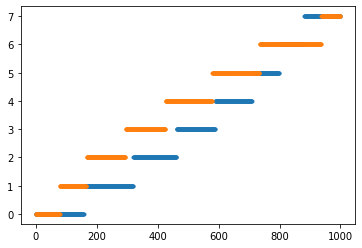

In [102]:
import matplotlib.pyplot as plt
plt.plot(sorted([div_r(r_ej_) for r_ej_ in r_ej_list]), '.')
plt.plot(sorted([div_h(h_ej_) for h_ej_ in h_ej_list]), '.')